# CNN Check

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Checking: ###############################
    
TFliteNamingAndVersion = "dig1320s3vd7"   # Used for tflite Filename

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.optimizer_v2 import adadelta as adadelta_v2
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

2022-01-12 18:39:45.521355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 18:39:45.521416: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load the model

* Load the model from the file with the "h5" file format

In [2]:
FileName = TFliteNamingAndVersion

#open(FileName + ".tflite", "rb").read(tflite_model)

#loaded_model = tf.keras.models.load_model('./dig1320s3vd2.tflite')
interpreter = tf.lite.Interpreter(FileName + ".tflite")

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(FileName)

# Show the model architecture
model.summary()

# Converting a SavedModel to a TensorFlow Lite model.
#converter = tf.lite.TFLiteConverter.from_saved_model("dig1320s3vd2.tflite")
#tflite_model = converter.convert()

#converter = tf.lite.TFLiteConverter.to_keras_model(tflite_model)
#model = converter.convert()


2022-01-12 18:39:47.977133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-12 18:39:47.977189: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 18:39:47.977213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b3bc0d41c73f): /proc/driver/nvidia/version does not exist
2022-01-12 18:39:47.977398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.

ziffer_vd_check_resize/3_dig1_20220112-080726.jpg 5
[[0.    0.    0.    0.009 0.    0.937 0.    0.    0.    0.054 0.   ]]


ziffer_vd_check_resize/3_dig1_20220112-185301.jpg 5
[[0.    0.    0.    0.093 0.    0.836 0.    0.    0.    0.071 0.   ]]


ziffer_vd_check_resize/4_dig001_20220101-232659.jpg 4
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


ziffer_vd_check_resize/5_dig0001_20220101-232659.jpg 5
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


ziffer_vd_check_resize/5_dig1_20220112-080226.jpg 5
[[0.    0.    0.    0.005 0.    0.982 0.    0.    0.    0.013 0.   ]]


ziffer_vd_check_resize/5_dig1_20220112-081254.jpg 5
[[0.    0.    0.    0.    0.    0.998 0.    0.    0.    0.002 0.   ]]


ziffer_vd_check_resize/5_dig1_20220112-184801.jpg 5
[[0.    0.    0.    0.002 0.    0.992 0.    0.    0.    0.006 0.   ]]


ziffer_vd_check_resize/5_dig1_20220112-185801.jpg 5
[[0.    0.    0.    0.022 0.    0.915 0.    0.    0.    0.063 0.   ]]


ziffer_vd_check_resize/6_dig01_20220101-232659.jpg 6
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


ziffer_vd_check_resize/6_dig100_20220101-232659.jpg 6
[[0.    0.001 0.    0.001 0.    0.001 0.996 0.    0.    0.    0.001]]


ziffer_vd_check_resize/6_dig10_20220101-232659.jpg 6
[[0.    0.001 0.006 0.004 0.003 0.023 0.96  0.    0.    0.    0.003]]


ziffer_vd_check_resize/6_dig1_20220101-232659.jpg 6
[[0.    0.    0.    0.    0.008 0.    0.992 0.    0.    0.    0.   ]]


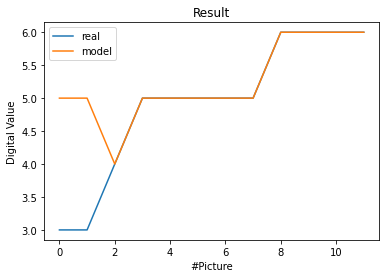

In [3]:
Input_dir='ziffer_vd_check_resize'
res = []
only_deviation = False
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

totalnumber=0
totaldiffs=0

for aktfile in files:
    totalnumber = totalnumber+1
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    target = base[0:2]
    if target == "10":
        zw1 = -1
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    prediction = model.predict(img)
    classes = np.argmax(prediction, axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            totaldiffs = totaldiffs+1
            if str(classes) != "-x1":
                print(aktfile + " " + str(expected_class) +  " " + str(classes))
                print(prediction)
                if show_wrong_image == True:
                    display(image_in)
    else:
        print(aktfile + " " + str(classes))
        print(prediction)
        if show_wrong_image == True:
            display(image_in)


        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

In [4]:
print("Total numbers of pictures: " + str(totalnumber))
print("Total numbers of differences: " + str(totaldiffs))

Total numbers of pictures: 12
Total numbers of differences: 0
